In [1]:
import os
from glob import glob
import cv2
import random
from tqdm import tqdm
import numpy as np
import glob
from keras.models import load_model
import keras

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [14]:
import os
import cv2
import random
import numpy as np
import glob
import matplotlib.pyplot as plt
import onnxruntime as ort

from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import utils  

In [6]:
DILATE_KERNEL = np.ones((15, 15), np.uint8)

INPUT = r'C:\Users\z004vp1t\Desktop\lung_unet'
INPUT_DIR = os.path.join(INPUT, "input")
SHENZHEN_MASK_DIR = os.path.join(INPUT_DIR, "shcxr-lung-mask", "mask", "mask")

shenzhen_mask_dir = os.path.join(SHENZHEN_MASK_DIR, '*.png') # lung_unet\input\shcxr-lung-mask\mask\mask


select_data = glob.glob(shenzhen_mask_dir)

shenzhen_datasets = random.sample(select_data, 10)

SEGMENTATION_SOURCE_DIR = os.path.join(INPUT_DIR, \
                                       "pulmonary-chest-xray-abnormalities")
SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "ChinaSet_AllFiles", \
                                  "ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")

In [28]:
for mask_file in tqdm(shenzhen_datasets):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)   # lung_unet\input\pulmonary-chest-xray-abnormalities\ChinaSet_AllFiles\ChinaSet_AllFiles\CXR_png
    print(base_file)
    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
    image = cv2.resize(image, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    filename, fileext = os.path.splitext(base_file)

    cv2.imwrite(os.path.join('./Shenzhen_test_onnx', base_file), \
                    image)
    cv2.imwrite(os.path.join('./Shenzhen_test_onnx', \
                                 "%s_mask%s" % (filename, fileext)), mask)
    cv2.imwrite(os.path.join('./Shenzhen_test_onnx', \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

 20%|██        | 2/10 [00:00<00:00,  9.57it/s]

CHNCXR_0620_1.png
CHNCXR_0261_0.png


 30%|███       | 3/10 [00:00<00:00,  9.62it/s]

CHNCXR_0112_0.png
CHNCXR_0372_1.png


 50%|█████     | 5/10 [00:00<00:00,  9.27it/s]

CHNCXR_0383_1.png
CHNCXR_0596_1.png


 70%|███████   | 7/10 [00:00<00:00,  8.39it/s]

CHNCXR_0093_0.png
CHNCXR_0606_1.png


 90%|█████████ | 9/10 [00:01<00:00,  7.92it/s]

CHNCXR_0548_1.png
CHNCXR_0011_0.png


100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


In [30]:
def dice_coef(y_true, y_pred): # measure two samples' similarity
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred) # loss

In [31]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img  # (1, 256, 256, 1) for keras 

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [32]:
model_path = './unet_lung_seg.hdf5' 
model = load_model(model_path, custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss})

In [33]:
onnx_model_path = './convert_model/result.onnx'
ort_session = ort.InferenceSession(onnx_model_path)

In [34]:
from glob import glob as glob_function
test_files = [test_file for test_file in glob_function(os.path.join('./Shenzhen_test_onnx', "*.png"))
              if ("_mask" not in test_file and
                  "_dilate" not in test_file and
                  "_predict" not in test_file)]
test_gen = test_generator(test_files, target_size=(512,512))
result = model.predict(test_gen, len(test_files), verbose=1)
print(result.shape)


10/10 [==============================] - 4s 335ms/step
(10, 512, 512, 1)


In [35]:
test_gen = utils.test_generator(test_files, target_size=(512,512))
input_data_list = [data for data in test_gen]  # 这将是一个形状为(N, 1, 512, 512, 1)的列表
print(len(input_data_list))
input_data = np.vstack(input_data_list).astype(np.float32)  # 将列表转换为一个数组
results = ort_session.run(["conv2d_18"], {"input_1": input_data})

10


In [38]:
print(len(results))
print(results[0].shape)
save_result('./Shenzhen_test_onnx', results[0], test_files)

1
(10, 512, 512, 1)


In [13]:
from glob import glob as glob_function
test_files = [test_file for test_file in glob_function(os.path.join('./Shenzhen_test', "*.png"))
              if ("_mask" not in test_file and
                  "_dilate" not in test_file and
                  "_predict" not in test_file)]
test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict(test_gen, len(test_files), verbose=1)
# save_result('./Shenzhen_test', results, test_files)

10/10 [==============================] - 4s 353ms/step


In [37]:
print(test_files)

['./Shenzhen_test_onnx\\CHNCXR_0011_0.png', './Shenzhen_test_onnx\\CHNCXR_0093_0.png', './Shenzhen_test_onnx\\CHNCXR_0112_0.png', './Shenzhen_test_onnx\\CHNCXR_0261_0.png', './Shenzhen_test_onnx\\CHNCXR_0372_1.png', './Shenzhen_test_onnx\\CHNCXR_0383_1.png', './Shenzhen_test_onnx\\CHNCXR_0548_1.png', './Shenzhen_test_onnx\\CHNCXR_0596_1.png', './Shenzhen_test_onnx\\CHNCXR_0606_1.png', './Shenzhen_test_onnx\\CHNCXR_0620_1.png']


In [39]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


In [41]:
from keras.preprocessing.image import img_to_array, load_img

dice_scores = []

for i, file_path in enumerate(test_files):
   
    mask_path = file_path.replace('.png', '_mask.png')  

    true_mask = load_img(mask_path, color_mode='grayscale', target_size=(512, 512))
    true_mask = img_to_array(true_mask)
    true_mask = true_mask / 255.0  

    predicted_mask = results[0][i]
    predicted_mask = cv2.resize(predicted_mask, (512, 512))

    dice_score = dice_coef(true_mask, predicted_mask)
    dice_scores.append(dice_score)

In [42]:
import numpy as np

dice_scores_np = np.array(dice_scores)

mean_dice = np.mean(dice_scores_np)
std_dice = np.std(dice_scores_np)

print("Average Dice:", mean_dice)
print("Dice standard devitation:", std_dice)

Average Dice: 0.7864706
Dice standard devitation: 0.06719277


In [43]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]
    
    # mask_coord[0], mask_coord[1] are row and column coordinates of all non black pixels

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret # comnine image, mask and dilate

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)
    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

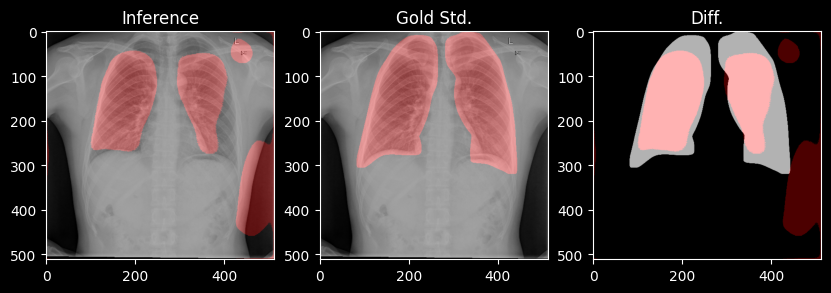

In [44]:
import matplotlib.pyplot as plt

path = test_files[0]
image = cv2.imread(path)
predict_image = cv2.imread(path.replace('.png', '_predict.png')  )
mask_image = cv2.imread(path.replace('.png', '_dilate.png'))


fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].set_title("Inference")
axs[0].imshow(add_colored_mask(image, predict_image))
axs[1].set_title("Gold Std.")
axs[1].imshow(add_colored_mask(image, mask_image))
axs[2].set_title("Diff.")
axs[2].imshow(diff_mask(mask_image, predict_image))

In [3]:
import onnx
model = onnx.load("./convert_model/result.onnx")

In [4]:
print("Input Node Names:", [input.name for input in model.graph.input])
print("Output Node Names:", [output.name for output in model.graph.output])

Input Node Names: ['input_1']
Output Node Names: ['conv2d_18']
